In [0]:
!pip install pyspellchecker
!pip install gensim

In [0]:
import tqdm
import itertools
import re
import nltk
#nltk.download('stopwords')
import string
import pandas as pd
import collections
import seaborn as sns
from nltk.tag import pos_tag
from nltk.tag import map_tag
from spellchecker import SpellChecker
from nltk.stem import PorterStemmer,WordNetLemmatizer
import numpy as np
nltk.download('maxent_ne_chunker')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('universal_tagset')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import ComplementNB,MultinomialNB,GaussianNB
from sklearn import metrics
import collections
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopword

In [0]:
#Mount the Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def convertToSentence(record):
    return (nltk.sent_tokenize(record))

In [0]:
def wordTokenize(sentences):
    return ([nltk.word_tokenize(sent) for sent in sentences])

In [0]:
def tagPOS(word_tokenized):
    return ([nltk.pos_tag(sent) for sent in word_tokenized])

In [0]:
#METHOD NOT USED IN FINAL MODEL#
def processDataForUnigram(pos_tagged):
    #Approach for Unigram Model
    #1. Find the Named Entity(Exclude Proper Nouns)
    #2. Reduce the lengthing of Non Named Entity Words followed by Spell Correction
    #3.Do stemming of the words using PorterStemmer
    #4.Remove Stop Words
    #5.Remove all the punctuations
    #Keep only alphabetical
    stop=stopwords.words('english')
    cleaned_tags=[]
    spell=SpellChecker()
    porter=PorterStemmer()
    regex = re.compile('[^a-zA-Z]')
    pos_to_consider=['JJ','JJR','JJS','MD','RB','RBR','RBS','UH','VB','VBD','VBG','VBN','VBP','VBZ','NN']#only keep certain POS tags(adj,adverbs,verbs etc)
    for item in pos_tagged:
        sent=[]
        tree=nltk.ne_chunk(item, binary=True)

        for val in tree:
            if isinstance(val,nltk.tree.Tree):
               # sent.append((' '.join([w for w,t in val]),'NE'))
                 sent.append(' '.join([w for w,t in val]))#Dont do any preprocessing on named entity
            else:
                 #These are not named entities. So do spell correction on them        
                if(len(val[0])>=3 and val[1] in pos_to_consider):  #exclude words having less than 3 characters               
                    word=val[0]
                    word=reduce_lengthening(text=word)#Reduce Lengthing
                    if spell.unknown(word):
                        word=spell.correction(word)#Spell Correction
                    word=porter.stem(word)#using stemming instead of lemmatization
                    if (word not in stop):
                        word=word.translate(word.maketrans('','',string.punctuation))#remove punctuations
                        word=regex.sub('', word)#remove non alphabets
                        sent.append(word)   
        cleaned_tags.append(sent)
    return (cleaned_tags)

In [0]:
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

In [0]:
def processReview(record):
    return(processDataForUnigram(tagPOS(wordTokenize(convertToSentence(record)))))

In [0]:
#load train data
train_data=pd.read_csv('/content/gdrive/My Drive/trip_advisor/train.csv')


In [0]:
#load test data
test_data=pd.read_csv('/content/gdrive/My Drive/trip_advisor/test.csv')

In [0]:
train_data.head()

,Description,Device_Used,Is_Response
0,The room was kind of clean but had a VERY stro...,Mobile,not happy
1,I stayed at the Crown Plaza April -- - April -...,Mobile,not happy
2,I booked this hotel through Hotwire at the low...,Tablet,not happy
3,Stayed here with husband and sons on the way t...,Desktop,happy
4,My girlfriends and I stayed here to celebrate ...,Tablet,not happy


In [0]:
#check if the device used to post review determines if the customer is happy or not
#it is possible that customers who post through mobile or tablet are more likely to be unhappy
#whereas those who post through desktop are more likely to be happy
train_data[['Device_Used','Is_Response','Description']].groupby(['Device_Used','Is_Response']).count()

Description
Device_Used Is_Response             
Desktop     happy              10595
            not happy           4431
Mobile      happy              10602
            not happy           4374
Tablet      happy               5324
            not happy           3606

**FREQUENCY BASED APPROACH USING TFIDF**

In [0]:
#GLOBAL Variables
stop=stopwords.words('english')
cleaned_tags=[]
spell=SpellChecker()
lemmatizer=WordNetLemmatizer()
regex = re.compile('[^a-zA-Z]')
pos_to_consider=['ADJ','VERB','X','ADV']#only keep certain POS tags(adj,adverbs,verbs etc)

def cleanText(lst):
    sent=[]
    for item in lst:  
        pos=map_tag('en-ptb', 'universal', item[1])#get universal tagset for POS
        if(len(item[0])>=3 and pos in pos_to_consider):  #exclude words having less than 3 characters               
            word=item[0]            
            word=reduce_lengthening(text=word)#Reduce Lengthing
            #if spell.unknown(word):
            #    word=spell.correction(word)#Spell Correction taking lot of time.so commenting it
            if (word not in stop):                
                word=word.translate(word.maketrans('','',string.punctuation))#remove punctuations
                word=regex.sub('', word)#remove non alphabets
                #word=porter.stem(word)#Stemming not giving good results
                word=lemmatizer.lemmatize(word,pos=getPos(pos))
                sent.append(word.lower()) 
    return sent
  
def getPos(tag):
  if tag=='ADJ':
    return('a')
  elif tag=='VERB':
    return('v')
  elif tag=='ADV':
    return('r')
  else:
    return('n')

In [0]:
#Cleaning the train data
texts_train=train_data['Description'].tolist()
cleaned=list(map(cleanText,(nltk.pos_tag_sents(map(nltk.word_tokenize,texts_train)))))
cleaned_sents_train=[' '.join(item) for item in cleaned]
train_data['Description']=np.array(cleaned_sents_train)

In [0]:
#cleaning the test data
texts_test=test_data['Description'].tolist()
t=map(cleanText,(nltk.pos_tag_sents(map(nltk.word_tokenize,texts_test))))
cleaned=list(t)
cleaned_sents_test=[' '.join(item) for item in cleaned]
test_data['Description']=np.array(cleaned_sents_test)

In [0]:
positive_words=(' '.join(train_data.loc[train_data['Is_Response']=='happy','Description']))
negative_words=(' '.join(train_data.loc[train_data['Is_Response']=='not happy','Description']))


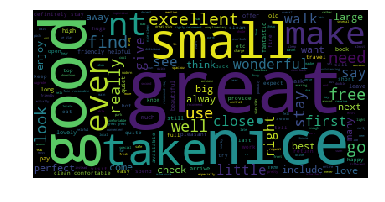

In [0]:
#wordcloud for positive words
cloud=WordCloud().generate(positive_words)
plt.imshow(cloud)
plt.axis('off')
plt.show()


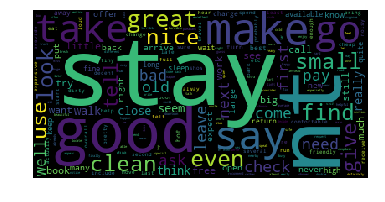

In [0]:
#word cloud for negative words
cloud=WordCloud().generate(negative_words)
plt.imshow(cloud)
plt.axis('off')
plt.show()


In [0]:
#Both the positive and negative words are lot in common. so we will have to exclude the high freq common words
pos_tokens=nltk.word_tokenize(positive_words)
neg_tokens=nltk.word_tokenize(negative_words)


In [0]:
#Identify the high frequency positive and negative words
most_common_pos=[word for word,count in collections.Counter(pos_tokens).most_common() if count>2000]
most_common_neg=[word for word,count in collections.Counter(neg_tokens).most_common() if count>2000]
words_to_remove=np.intersect1d(most_common_pos,most_common_neg)

In [0]:
words_to_remove=list(words_to_remove)#these are the high frequency words occurring in both positive and negative reviews

In [0]:
len(words_to_remove)

48

**UNIGRAM MODEL**

In [0]:
#Split into train and dev
X_train,X_dev,y_train,y_dev = train_test_split(train_data['Description'],train_data['Is_Response'],test_size=0.25, random_state = 25)

In [0]:
#vectorizer = TfidfVectorizer(min_df=50,max_df=7000,max_features=3000,stop_words=words_to_remove)#TFIDF not improving results
vectorizer = CountVectorizer(stop_words=words_to_remove,max_features=3000,analyzer='word')
X_train=vectorizer.fit_transform(X_train)#Fitting the count vectorizer only on train data
X_dev=vectorizer.transform(X_dev)
X_test=vectorizer.transform(test_data['Description'])

In [0]:
clf = MultinomialNB()
clf.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
#Accuracy on train
print(metrics.classification_report(y_train,clf.predict(X_train)))

              precision    recall  f1-score   support

       happy       0.89      0.92      0.90     19861
   not happy       0.82      0.75      0.78      9338

   micro avg       0.87      0.87      0.87     29199
   macro avg       0.85      0.84      0.84     29199
weighted avg       0.87      0.87      0.87     29199



In [0]:
pred=clf.predict(X_dev)

In [0]:
#Accuracy on Dev
print(metrics.classification_report(y_dev,pred))

              precision    recall  f1-score   support

       happy       0.89      0.91      0.90      6660
   not happy       0.80      0.75      0.77      3073

   micro avg       0.86      0.86      0.86      9733
   macro avg       0.84      0.83      0.84      9733
weighted avg       0.86      0.86      0.86      9733



In [0]:
########################
#Predictions on test set
test_pred=clf.predict(X_test)
result=np.column_stack((np.array(test_data['User_ID']),test_pred))
res=pd.DataFrame(result,columns=['User_ID','Is_Response'])
res.to_csv('/content/gdrive/My Drive/trip_advisor/output13_unigram_cv3000.csv',index=False)


**PS::The expected label on hackerearth is not_happy instead of the training label not happy. So after writing the submission file, manually change the label before submitting**

**ACCURACY ON TEST:0.858 on HackerEarth**

**BIGRAM MODEL**

In [0]:
#Split into train and dev
X_train,X_dev,y_train,y_dev = train_test_split(train_data['Description'],train_data['Is_Response'],test_size=0.25, random_state = 25)

In [0]:
vectorizer2 = CountVectorizer(stop_words=words_to_remove,max_features=3000,analyzer='word',ngram_range=(1,2))
X_train=vectorizer2.fit_transform(X_train)
X_dev=vectorizer2.transform(X_dev)
X_test=vectorizer2.transform(test_data['Description'])

In [0]:
clf = MultinomialNB()
clf.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
#Accuracy on Dev
print(metrics.classification_report(y_dev,clf.predict(X_dev)))

              precision    recall  f1-score   support

       happy       0.89      0.90      0.90      6660
   not happy       0.78      0.76      0.77      3073

   micro avg       0.86      0.86      0.86      9733
   macro avg       0.84      0.83      0.83      9733
weighted avg       0.86      0.86      0.86      9733



In [0]:
########################
#Predictions on test set
test_pred=clf.predict(X_test)
result=np.column_stack((np.array(test_data['User_ID']),test_pred))
res=pd.DataFrame(result,columns=['User_ID','Is_Response'])
res.to_csv('/content/gdrive/My Drive/trip_advisor/output12.csv',index=False)

**ACCURACY ON TEST:0.848**

**USING DOC2VEC APPROACH TO CAPTURE CONTEXT**

In [0]:
#############trying word2vec############
from gensim.models import Doc2Vec 
from gensim.models.doc2vec import TaggedDocument

In [0]:
regex = re.compile('[^a-zA-Z\!]')
punc=string.punctuation.replace('!','')
def cleanTextForDoc2Vec(lst):
    sent=[]
    for item in lst:        
        word=item            
        word=reduce_lengthening(text=word)#Reduce Lengthing
        word=word.translate(word.maketrans('','',punc))#remove punctuations except !
        word=regex.sub('', word)#remove non alphabets
        sent.append(word.lower()) 
    return sent

In [0]:
#The cleaning process for Doc2Vec will be different from normal Tfidf. Here we will just remove the punctuations,non alphabets and convert everything to lower case
#we will not remove stop words or use stemming
#Loading the data again
train_data=pd.read_csv('/content/gdrive/My Drive/trip_advisor/train.csv')
test_data=pd.read_csv('/content/gdrive/My Drive/trip_advisor/test.csv')


In [0]:
#cleaning the train data
texts_train=train_data['Description'].tolist()
t=map(cleanTextForDoc2Vec,(map(nltk.word_tokenize,texts_train)))
cleaned=list(t)
train_data['Description']=np.array(cleaned)

In [0]:
#cleaning the test data
texts_test=test_data['Description'].tolist()
t=map(cleanTextForDoc2Vec,(map(nltk.word_tokenize,texts_test)))
cleaned=list(t)
test_data['Description']=np.array(cleaned)

In [0]:
labeled_recs=[]
counter=0
for rec,label in zip(train_data['Description'],train_data['Is_Response']):
  T=TaggedDocument(rec,[label,counter])
  labeled_recs.append(T)
  counter+=1

In [0]:
model=Doc2Vec(labeled_recs,vector_size=200, min_count=20,window=2,epochs=20)

In [0]:
#convert it into feature vector for input into classifier model
labels, docvectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in labeled_recs])
 

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
X_train,X_dev,y_train,y_dev = train_test_split(np.array(docvectors),labels,test_size=0.25, random_state = 25)

In [0]:
minmaxscaler=preprocessing.MinMaxScaler()
X_train=minmaxscaler.fit_transform(X_train)
X_dev=minmaxscaler.transform(X_dev)

In [0]:
svc=SVC(C=10).fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
pred=svc.predict(X_dev)

In [0]:
#Accuracy on Dev Set
print(metrics.classification_report(y_dev,pred))

              precision    recall  f1-score   support

       happy       0.87      0.94      0.90      6660
   not happy       0.84      0.71      0.77      3073

   micro avg       0.86      0.86      0.86      9733
   macro avg       0.86      0.82      0.84      9733
weighted avg       0.86      0.86      0.86      9733



In [0]:
#######PREDICT ON TEST###########

In [0]:
test_vectors=[model.infer_vector(words, steps=30) for words in test_data['Description']]
test_vectors=minmaxscaler.transform(test_vectors)
test_pred=svc.predict(test_vectors)
result=np.column_stack((np.array(test_data['User_ID']),test_pred))
res=pd.DataFrame(result,columns=['User_ID','Is_Response'])
res.to_csv('/content/gdrive/My Drive/trip_advisor/svc2.csv',index=False)

**TEST ACCURACY: 0.856**